In [1]:
from cellmemory import cm
from cellmemory import plot
import numpy as np
import pandas as pd
import scanpy as sc
import os
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

# Train model

We train CellMemory using CITE-seq data as the reference and integrate the Asian Immune Diversity Atlas (AIDA).index
In this example, we focus on CellMemory's Hierarchical Interpretation of CD8 TCM cells.

The immune data path: https://figshare.com/account/projects/241457/articles/28925450  
Full access to the dataset can be obtained via the CellxGene database  
CITE-seq: https://cellxgene.cziscience.com/collections/b0cf0afa-ec40-4d65-b570-ed4ceacc6813  
AIDA: https://cellxgene.cziscience.com/collections/ced320a1-29f3-47c1-a735-513c7084d508  

In [2]:
# train
batch_size = 90
Dataset = 'immune_citeseq_train.h5ad'  # train data path
Label = 'celltype.l2'   # cell type
Project = 'cm_pbmc_aida'  # Project name

In [3]:
# Using our trained CellMemory model.
# cm.train(Dataset, Label=Label, Project=Project, batch_size=batch_size,exp_bin='bin_scale', use_amp=False, mode='full')

# Inference
During the inference, the parameter settings must remain consistent with those used during the training.  
We downsampled 200k cells from the AIDA dataset.

In [4]:
batch_size = 128
test_data = sc.read_h5ad('immune_aida_test.h5ad')
adata_pred = cm.generate(test_data, Project=Project, batch_size=batch_size, out_tag=False,exp_bin='bin_scale', mode='full')


Loading Model from: cm_pbmc_aida
Reference Categories: 31
Query set: (200000, 4000)
Query Max bins: 50
Ref Max bins: 50
use topk: False
==> Resuming from checkpoint..
Using 1 GPU.
CellMemory is deciphering query cells..


### Get cell embedding using cls embedding

In [5]:
cls=adata_pred.cls

### generate memory scores for CD8 TCM cells and visualized.

In [6]:
cls_cd8tcm=cls[cls.obs.cm_pred.isin(['CD8 TCM']),:].copy()
adata_cd8tcm=test_data[cls_cd8tcm.obs.index,:].copy()

In [7]:
cls_cd8tcm

AnnData object with n_obs × n_vars = 2485 × 256
    obs: 'cm_pred', 'cm_pred_prob'

In [8]:
adata_pred_cd8tcm = cm.generate(adata_cd8tcm, Project=Project, batch_size=batch_size, out_tag=True, tag2cls=False, exp_bin='bin_scale', use_amp=False,mode='full')
memory_score = adata_pred_cd8tcm.memory_score  # (2485, 4000, 8)


Loading Model from: cm_pbmc_aida
Reference Categories: 31
Query set: (2485, 4000)
Query Max bins: 50
Ref Max bins: 50
use topk: False
==> Resuming from checkpoint..
Using 1 GPU.
CellMemory is deciphering query cells..


In [9]:
import anndata as ad
adata_attn=ad.AnnData(memory_score.mean(axis=0).T)
adata_attn.var.index=adata_cd8tcm.var.index

top50_per_slot = {}
data = adata_attn.X.toarray() if hasattr(adata_attn.X, "toarray") else adata_attn.X

for i, slot in enumerate(adata_attn.obs_names):
    expr = data[i, :]
    top_idx = np.argsort(expr)[::-1][:50]
    top_genes = adata_attn.var_names[top_idx].tolist()
    top50_per_slot[slot] = top_genes

df_top50 = pd.DataFrame.from_dict(top50_per_slot)
df_top50.index = [f"top_{i+1}" for i in df_top50.index]
df_top50.columns = [f"slot_{i+1}" for i in df_top50.columns.astype(int)]

### for each slot, show the top 5 genes

In [10]:
top5_dict = {slot: genes[:5] for slot, genes in top50_per_slot.items()}
top5_dict = {
    f"slot_{int(k) + 1}": v
    for k, v in top5_dict.items()
}

adata_attn.obs['Slots'] = list(df_top50.columns)
plt.rcParams['pdf.fonttype']=42

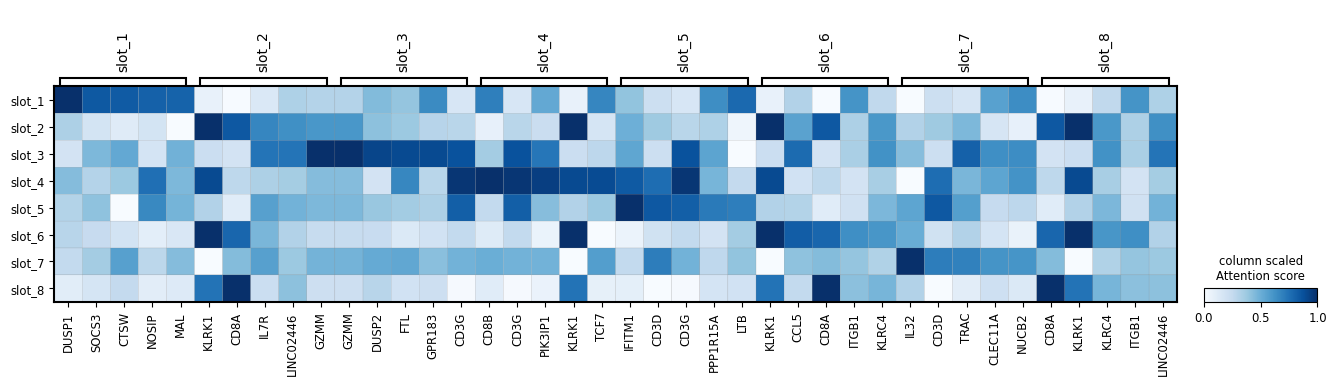

<Figure size 640x480 with 0 Axes>

In [11]:
sc.pl.matrixplot(adata_attn, top5_dict, groupby='Slots', cmap='Blues',standard_scale='group',\
 colorbar_title='column scaled\nAttention score')
plt.savefig(Project+'/CD8TCM_attn.pdf', dpi=300, bbox_inches="tight")

In [12]:
df_top50.to_csv(Project+"/memory_slot_tags.csv")
adata_attn.write(Project+'/memory_score_cd8tcm.h5ad')